# Uploading libraries

In [49]:
# Fundamental libraries

import os
import random
import time
import copy

# Working libraries
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb
from torch.autograd import Variable
from sklearn.metrics import classification_report
import torch.utils.data as data
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as transform
from torchvision.transforms.functional import convert_image_dtype
from PIL import Image
from transformers import AutoImageProcessor, ViTImageProcessor, ViTForImageClassification, ViTConfig, ResNetForImageClassification, ResNetConfig, BeitForImageClassification, BeitConfig, BeitImageProcessor, AutoFeatureExtractor
import torchvision.transforms.functional as TF
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import f1_score
from importlib import reload
import utility
reload(utility)
from utility import load_data, plot_confusion_matrix, plot_average_f1_scores, train_model, get_classification_details, get_hard_disk_path, show_samples, plot_features_importance, visualize_correlation, get_shap

# Evaluation
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

# Model Recommendations
VGG-16: Despite being relatively deep, VGG-16 can still be effective on smaller datasets, especially when used with transfer learning. Its simplicity and well-understood architecture make it a good starting point.

ResNet-50: ResNet models, especially the shallower ones like ResNet-50, are known for their ability to avoid overfitting through the use of residual connections. This can be beneficial for learning from small datasets.

MobileNet: Designed for mobile and resource-constrained environments, MobileNets are lightweight and efficient, which can be advantageous when training data is limited.

SqueezeNet: This network achieves AlexNet-level accuracy with significantly fewer parameters. Its compact architecture makes it suitable for small datasets and limited computational resources.

# FILE PATHS on local environment

#### Each folder path represent class (label) :

**Folder name - calss name : description**

0 - 0 class : dead

1 - 1 class : empty

2 - 2 class : keep0

3 - 3 class : keep1

4 - 4 class : keep2

5 - 5 class : reseed0

6 - 6 class : reseed1

7 -  7 class : split

In [50]:
# paths for data upload
FILE_PATH = "E:/New_data_Maxim/croped_images/"
TRAIN_FEATURES_PATH_0 = FILE_PATH + 'keep0' 
TRAIN_FEATURES_PATH_1 = FILE_PATH + 'keep1'
TRAIN_FEATURES_PATH_2 = FILE_PATH + 'keep2'
TRAIN_FEATURES_PATH_3 = FILE_PATH + 'reseed0'
TRAIN_FEATURES_PATH_4 = FILE_PATH + 'reseed1'
TRAIN_FEATURES_PATH_5 = FILE_PATH + 'split'

# list with pathe
PATHES_LIST = [TRAIN_FEATURES_PATH_0,TRAIN_FEATURES_PATH_1,TRAIN_FEATURES_PATH_2,TRAIN_FEATURES_PATH_3,TRAIN_FEATURES_PATH_4, TRAIN_FEATURES_PATH_5]

# Data set : train & test

The data was divided into training and testing sets for each class, with a split of 80% for training and 20% for testing, maintaining the same ratio for each class. However, the dataset exhibits an imbalance issue, with one class having a significantly larger number of samples compared to the other class.

In [51]:
labels = ['keep0', 'keep1', 'keep2', 'reseed0', 'reseed1', 'split']
for i, path in enumerate(PATHES_LIST):
    print(path)

E:/New_data_Maxim/croped_images/keep0
E:/New_data_Maxim/croped_images/keep1
E:/New_data_Maxim/croped_images/keep2
E:/New_data_Maxim/croped_images/reseed0
E:/New_data_Maxim/croped_images/reseed1
E:/New_data_Maxim/croped_images/split


In [70]:
class CustomImageDataset_train(Dataset):
    def __init__(self, img_paths, img_labels, transform=None, model_name=None):
        self.img_sort = img_paths
        self.img_labels = img_labels
        self.transform = transform
        self.processor = None

        # Load the processor if a model name is given
        if model_name == "microsoft/resnet-50":
            self.processor = AutoImageProcessor.from_pretrained(model_name)
        if model_name == "microsoft/resnet-18":
            self.processor = AutoFeatureExtractor.from_pretrained(model_name)
        if model_name == "microsoft/beit-base-patch16-224-pt22k-ft22k":
            self.processor = BeitImageProcessor.from_pretrained(model_name)
        if model_name == "google/vit-base-patch16-224":
            self.processor = ViTImageProcessor.from_pretrained(model_name)

        self.original_len = len(self.img_sort)

    def __len__(self):
        return self.original_len * 4 #up to 8 for data augmentation

    def __getitem__(self, idx):
        original_idx = idx % self.original_len
        augmentation_index = idx // self.original_len

        # Load image
        img_path = self.img_sort[original_idx]
        try:
            PIL_image = Image.open(img_path).convert("L")

            # The image can be converted to tensor using
            image = transform.to_tensor(PIL_image)
            image = image * 255
            image = image.type(torch.uint8)
        except Exception as e:
            print(f"Error reading image {img_path}: {e}")
            # Handle error (e.g., by skipping this sample or using a default image)
        if image.shape[0] == 1:
            image = image.repeat(3, 1, 1)

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # Apply augmentations
        image = self.augmentation(image, augmentation_index)

        # Process the image if a processor is set
        if self.processor:
            image = self.processor(images=image, return_tensors="pt").pixel_values.squeeze()

        # Get label
        label = torch.tensor(self.img_labels[original_idx], dtype=torch.long)

        return image, label
        
    def augmentation(self, image, augmentation_index):
        # Random horizontal flipping
        flip_type = augmentation_index % 2  # 0 for horizontal, 1 for vertical
        rotation = (augmentation_index // 2) * 90  # Will give 0, 90, 180, 270

        # Apply flip
        if flip_type == 0:
            image = TF.hflip(image)
        else:
            image = TF.vflip(image)

        # Apply rotation
        image = TF.rotate(image, rotation)

        return image

### Separate data to train and test data with ratio 0.8 in test data

To utilize the CustomImageDataset_test and CustomImageDataset_train, it is necessary to specify the desired transformations for each case, such as Normalize and CenterCrop.

The following code demonstrates how to define the transformations:

For test data transformation using CenterCrop:

In [71]:
class CustomImageDataset_test(Dataset):
    def __init__(self, img_paths, img_labels, transform=None, model_name=None):
        self.img_sort = img_paths   # List of image paths
        self.img_labels = img_labels # Corresponding labels for each image
        self.transform = transform
        self.processor = None

        # Load the processor if a model name is given
        if model_name == "microsoft/resnet-50":
            self.processor = AutoImageProcessor.from_pretrained(model_name)
        if model_name == "microsoft/resnet-18":
            self.processor = AutoFeatureExtractor.from_pretrained(model_name)
        if model_name == "microsoft/beit-base-patch16-224-pt22k-ft22k":
            self.processor = BeitImageProcessor.from_pretrained(model_name)
        if model_name == "google/vit-base-patch16-224":
            self.processor = ViTImageProcessor.from_pretrained(model_name)
        
        self.len = len(self.img_sort)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        img_path = self.img_sort[idx]
        try:
            PIL_image = Image.open(img_path).convert("L")

            # The image can be converted to tensor using
            image = transform.to_tensor(PIL_image)
            image = image * 255
            image = image.type(torch.uint8)
        except Exception as e:
            print(f"Error reading image {img_path}: {e}")
            # Handle error (e.g., by skipping this sample or using a default image)

        label = torch.tensor(self.img_labels[idx], dtype=torch.long)
        
        if image.shape[0] == 1:
            image = image.repeat(3, 1, 1)
            
        if self.transform:
            image = self.transform(image)

        if self.processor:
            image = self.processor(images=image, return_tensors="pt").pixel_values.squeeze()

        return image, label

Training on fold 1/2


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


cuda


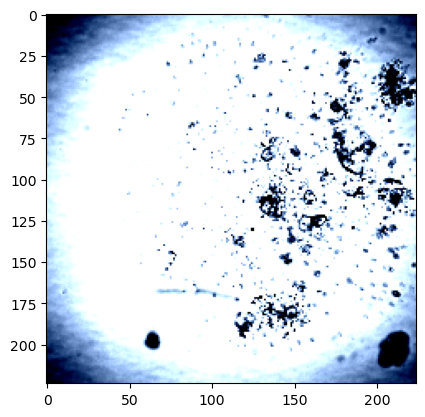

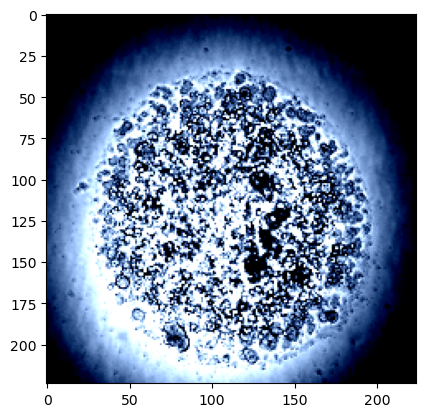

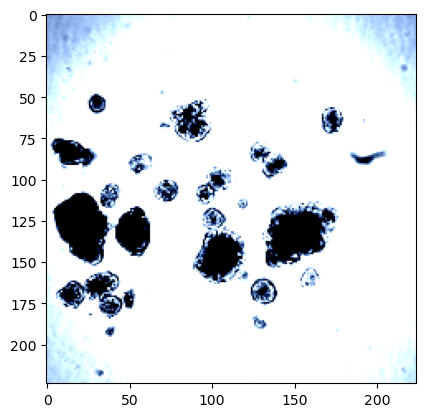

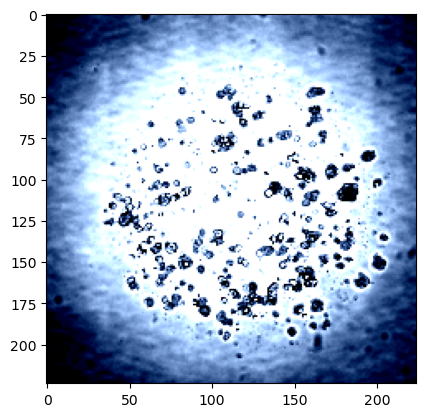

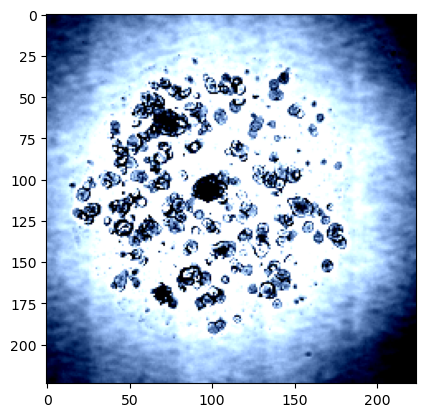

Epoch 1, Train Loss: 1.1674718704629452, Validation Loss: 1.270163853963216, Accuracy: 46.16419919246299 %
Class 0 F1 Score: 0.6578449905482041
Class 1 F1 Score: 0.43762781186094063
Class 2 F1 Score: 0.21428571428571427
Class 3 F1 Score: 0.0
Class 4 F1 Score: 0.430939226519337
Class 5 F1 Score: 0.058823529411764705
Epoch 2, Train Loss: 0.8214156018926743, Validation Loss: 0.7964293944338957, Accuracy: 68.50605652759084 %
Class 0 F1 Score: 0.7815699658703071
Class 1 F1 Score: 0.3859649122807018
Class 2 F1 Score: 0.6593406593406593
Class 3 F1 Score: 0.0
Class 4 F1 Score: 0.8659793814432989
Class 5 F1 Score: 0.4705882352941177
Epoch 3, Train Loss: 0.7019620284121088, Validation Loss: 0.8660487234592438, Accuracy: 63.39165545087483 %
Class 0 F1 Score: 0.7164179104477612
Class 1 F1 Score: 0.4846796657381616
Class 2 F1 Score: 0.6360424028268551
Class 3 F1 Score: 0.0
Class 4 F1 Score: 0.7796610169491526
Class 5 F1 Score: 0.5862068965517241
Epoch 4, Train Loss: 0.5769571826813069, Validation L

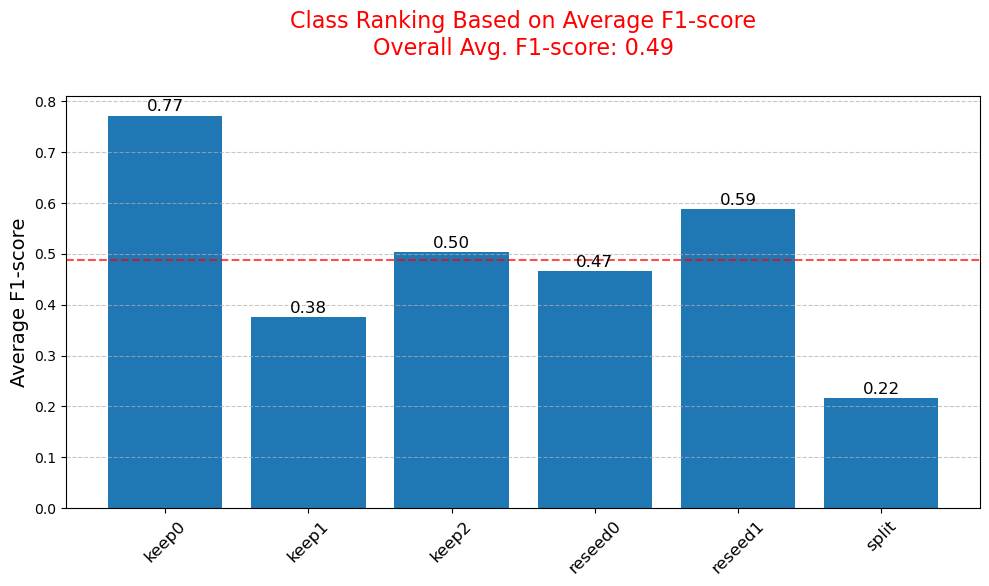

Training on fold 2/2


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


cuda


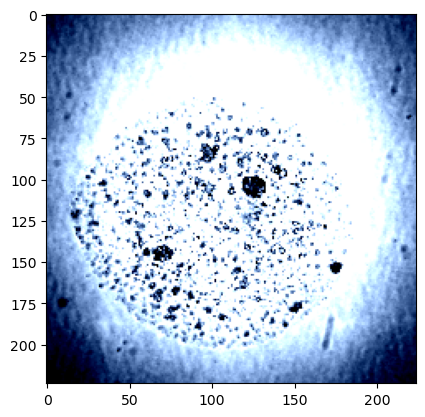

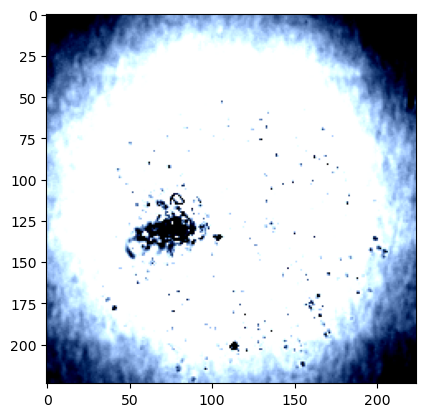

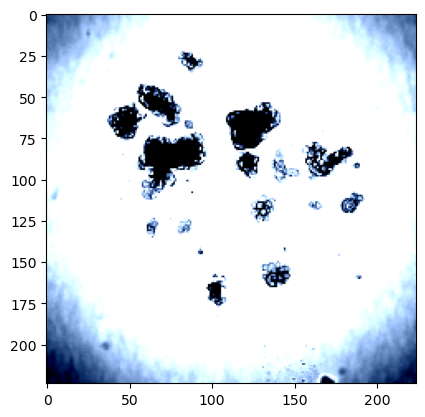

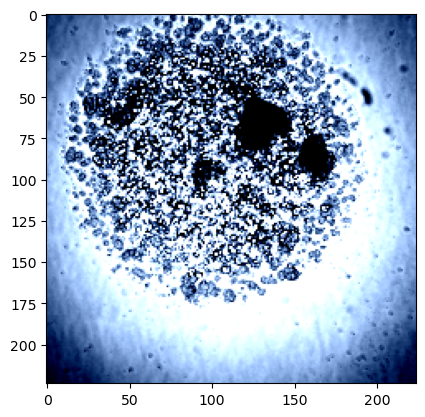

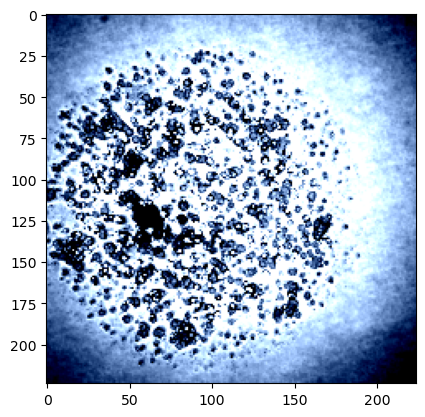

Epoch 1, Train Loss: 1.135046031880886, Validation Loss: 1.2505722890297573, Accuracy: 50.47106325706595 %
Class 0 F1 Score: 0.6462035541195476
Class 1 F1 Score: 0.3924731182795699
Class 2 F1 Score: 0.32989690721649484
Class 3 F1 Score: 0.0
Class 4 F1 Score: 0.5482233502538071
Class 5 F1 Score: 0.39999999999999997
Epoch 2, Train Loss: 0.7835028133493789, Validation Loss: 0.7934454331795374, Accuracy: 68.64064602960968 %
Class 0 F1 Score: 0.7622259696458685
Class 1 F1 Score: 0.4100418410041841
Class 2 F1 Score: 0.6554621848739496
Class 3 F1 Score: 0.0
Class 4 F1 Score: 0.8612099644128114
Class 5 F1 Score: 0.6486486486486486
Epoch 3, Train Loss: 0.669943150053633, Validation Loss: 1.1327288473645847, Accuracy: 60.296096904441455 %
Class 0 F1 Score: 0.7447154471544715
Class 1 F1 Score: 0.3826086956521739
Class 2 F1 Score: 0.3624161073825503
Class 3 F1 Score: 0.0
Class 4 F1 Score: 0.6721311475409836
Class 5 F1 Score: 0.49019607843137253
Epoch 4, Train Loss: 0.5969105616528937, Validation L

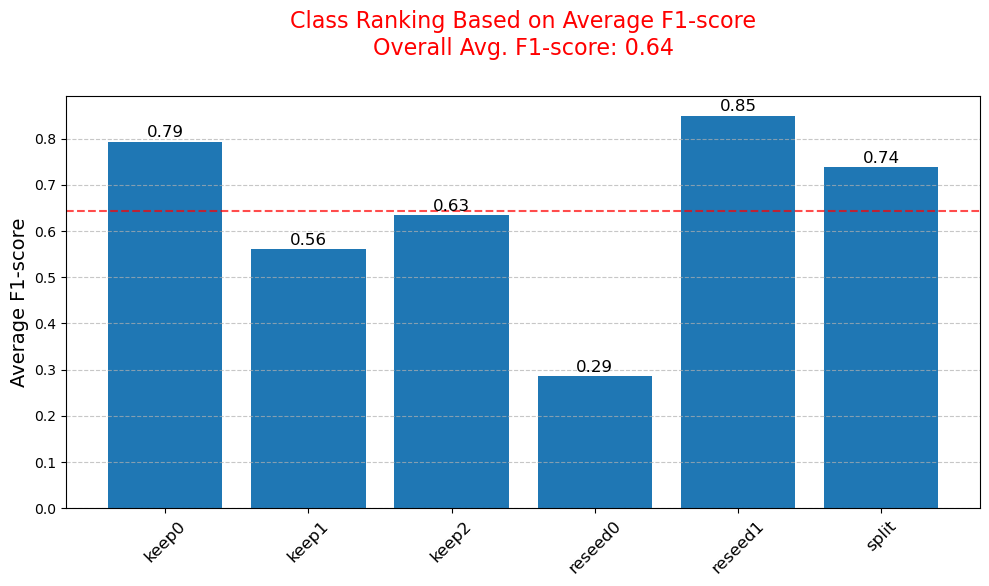

Training on fold 1/2


The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.


cuda


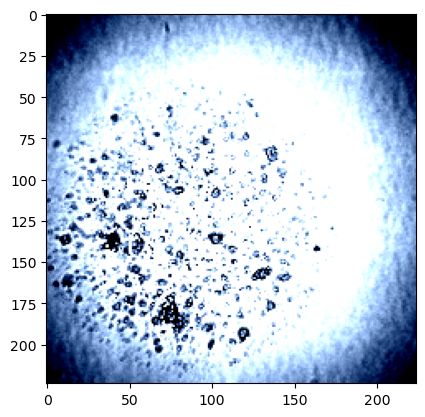

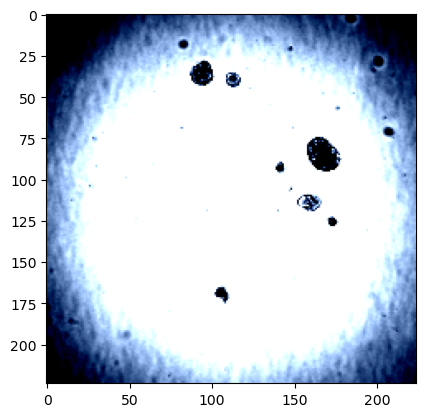

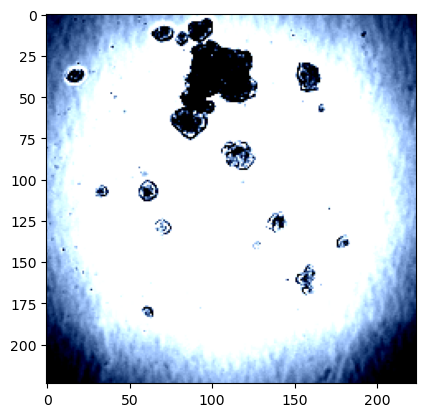

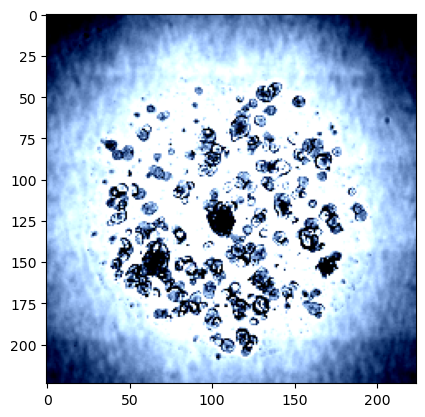

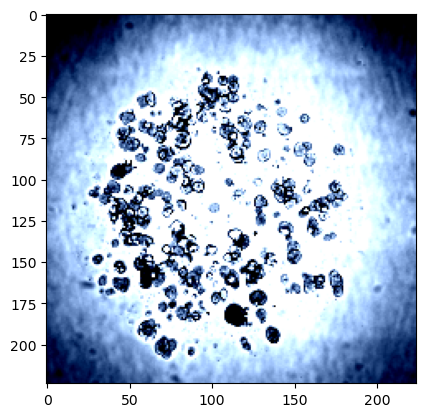

Epoch 1, Train Loss: 0.9511465366850508, Validation Loss: 0.867379941046238, Accuracy: 63.12247644683715 %
Class 0 F1 Score: 0.7731958762886599
Class 1 F1 Score: 0.5454545454545455
Class 2 F1 Score: 0.16
Class 3 F1 Score: 0.0
Class 4 F1 Score: 0.7543859649122806
Class 5 F1 Score: 0.5858585858585859
Epoch 2, Train Loss: 0.6532255005329213, Validation Loss: 0.6528672433147827, Accuracy: 72.94751009421265 %
Class 0 F1 Score: 0.785862785862786
Class 1 F1 Score: 0.6270627062706271
Class 2 F1 Score: 0.5882352941176471
Class 3 F1 Score: 0.5185185185185185
Class 4 F1 Score: 0.87248322147651
Class 5 F1 Score: 0.7397260273972602
Epoch 3, Train Loss: 0.5301486253738403, Validation Loss: 0.9275088437522451, Accuracy: 65.54508748317632 %
Class 0 F1 Score: 0.7652733118971062
Class 1 F1 Score: 0.29441624365482233
Class 2 F1 Score: 0.6211604095563139
Class 3 F1 Score: 0.08333333333333333
Class 4 F1 Score: 0.89198606271777
Class 5 F1 Score: 0.0
Epoch 4, Train Loss: 0.4062744055656677, Validation Loss: 

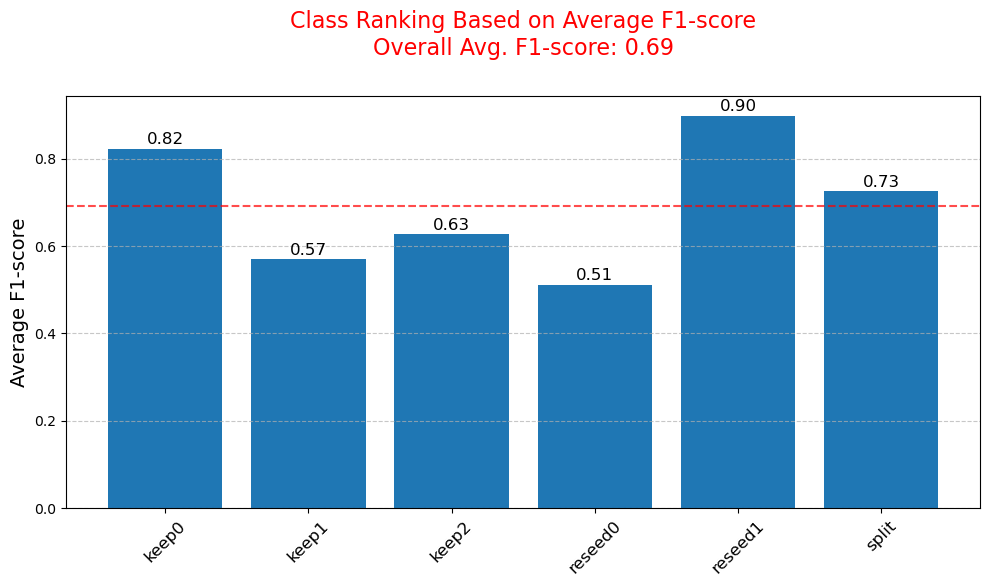

Training on fold 2/2


The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.


cuda


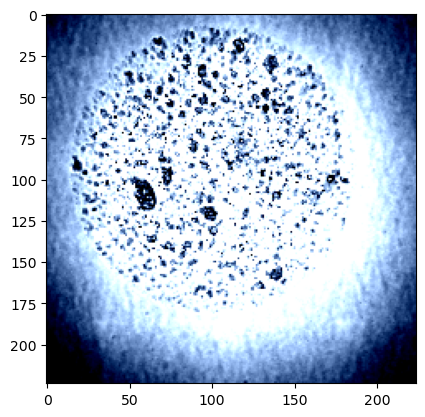

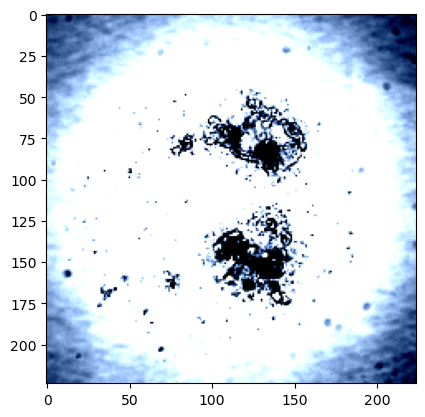

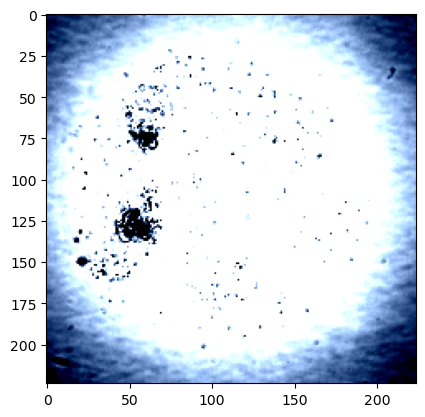

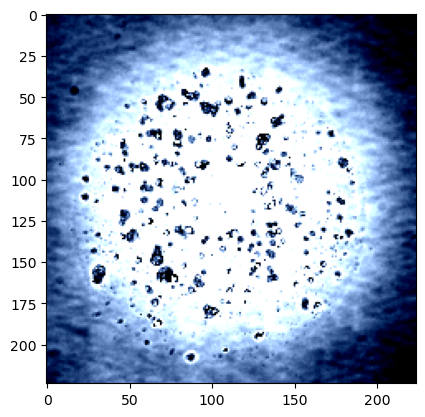

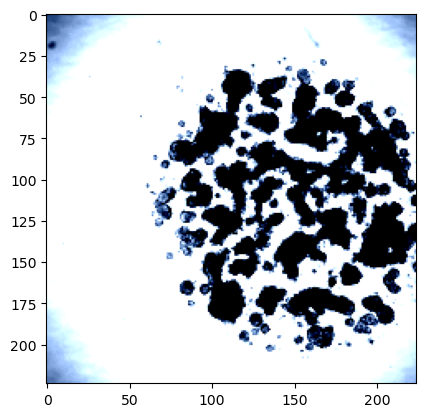

Epoch 1, Train Loss: 0.98664357814383, Validation Loss: 0.8899226561188698, Accuracy: 63.39165545087483 %
Class 0 F1 Score: 0.7302752293577982
Class 1 F1 Score: 0.5133333333333333
Class 2 F1 Score: 0.38509316770186336
Class 3 F1 Score: 0.0
Class 4 F1 Score: 0.8292682926829269
Class 5 F1 Score: 0.5904761904761904
Epoch 2, Train Loss: 0.6357829361519916, Validation Loss: 0.8317871813972791, Accuracy: 69.85195154777928 %
Class 0 F1 Score: 0.7999999999999999
Class 1 F1 Score: 0.4382470119521912
Class 2 F1 Score: 0.6577777777777778
Class 3 F1 Score: 0.5151515151515152
Class 4 F1 Score: 0.8333333333333334
Class 5 F1 Score: 0.6086956521739131
Epoch 3, Train Loss: 0.5266823020387204, Validation Loss: 0.770929696659247, Accuracy: 69.85195154777928 %
Class 0 F1 Score: 0.7857142857142857
Class 1 F1 Score: 0.5054151624548737
Class 2 F1 Score: 0.6666666666666666
Class 3 F1 Score: 0.4615384615384615
Class 4 F1 Score: 0.840677966101695
Class 5 F1 Score: 0.6597938144329897
Epoch 4, Train Loss: 0.40001

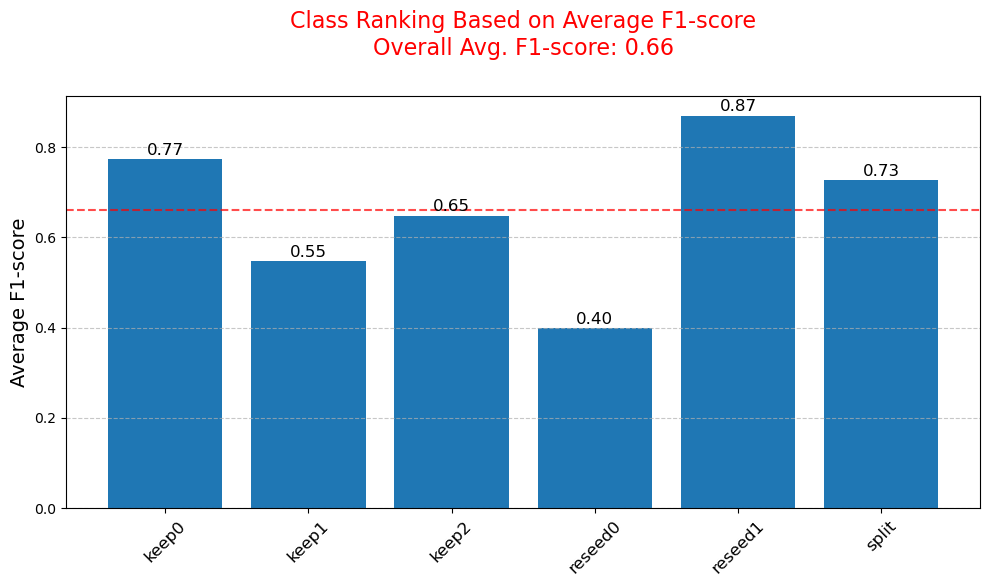

Training on fold 1/2
cuda


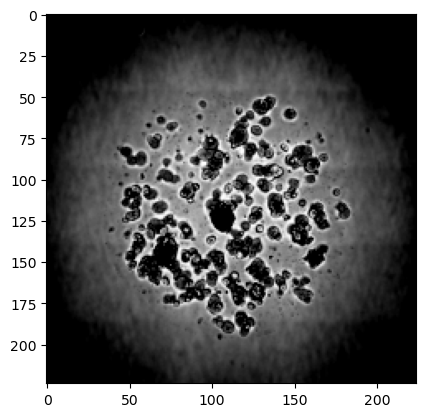

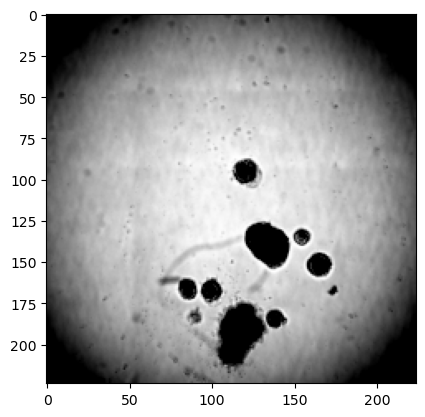

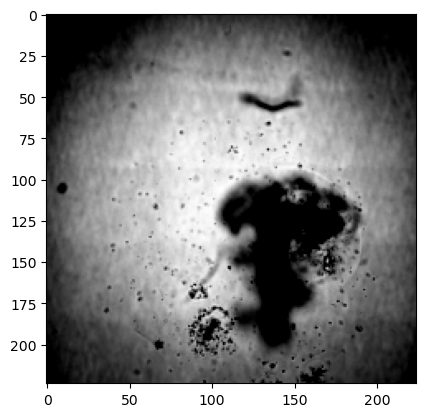

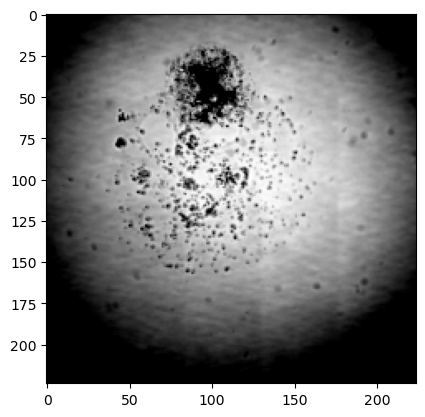

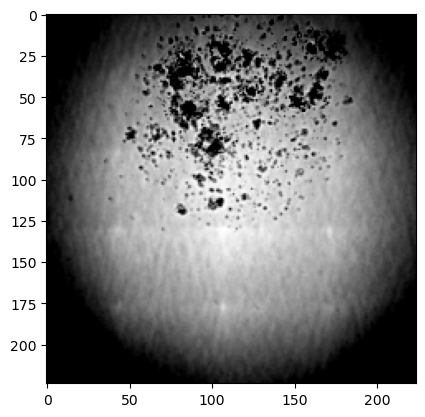

Epoch 1, Train Loss: 1.4655459053972935, Validation Loss: 1.3308094988266628, Accuracy: 41.857335127860026 %
Class 0 F1 Score: 0.4444444444444445
Class 1 F1 Score: 0.4545454545454545
Class 2 F1 Score: 0.06451612903225806
Class 3 F1 Score: 0.0
Class 4 F1 Score: 0.6086956521739131
Class 5 F1 Score: 0.23076923076923073
Epoch 2, Train Loss: 1.110689271003642, Validation Loss: 1.0628134335080783, Accuracy: 57.46971736204576 %
Class 0 F1 Score: 0.6542056074766356
Class 1 F1 Score: 0.14942528735632185
Class 2 F1 Score: 0.418848167539267
Class 3 F1 Score: 0.0
Class 4 F1 Score: 0.8178137651821863
Class 5 F1 Score: 0.5490196078431373
Epoch 3, Train Loss: 0.9654183806257045, Validation Loss: 0.8495564845701059, Accuracy: 67.02557200538358 %
Class 0 F1 Score: 0.7346938775510204
Class 1 F1 Score: 0.5408450704225353
Class 2 F1 Score: 0.5497630331753554
Class 3 F1 Score: 0.0
Class 4 F1 Score: 0.8590604026845639
Class 5 F1 Score: 0.6605504587155963
Epoch 4, Train Loss: 0.8415024343957292, Validation L

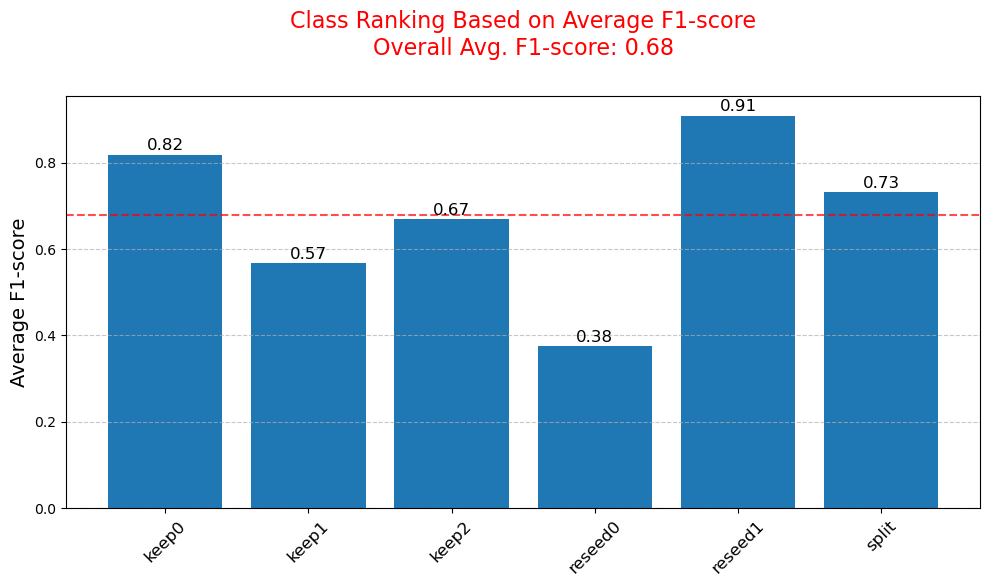

Training on fold 2/2
cuda


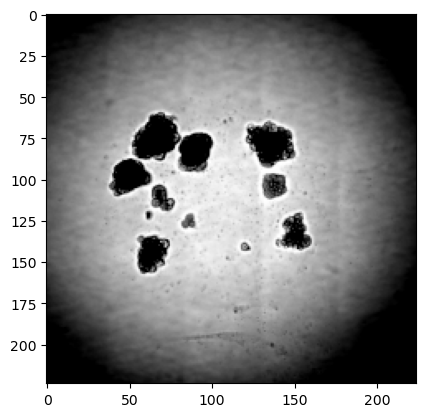

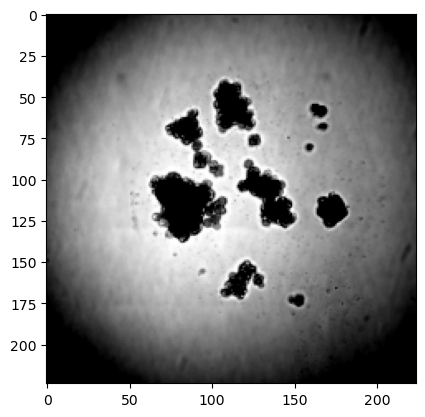

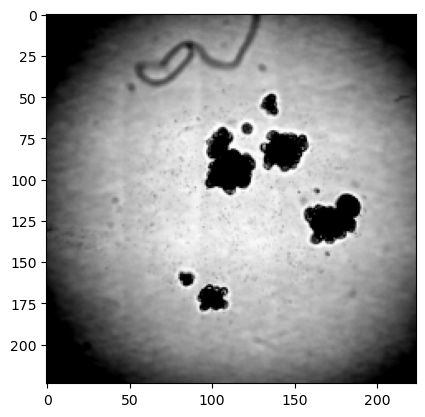

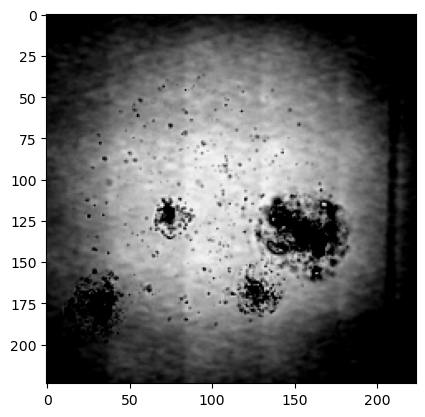

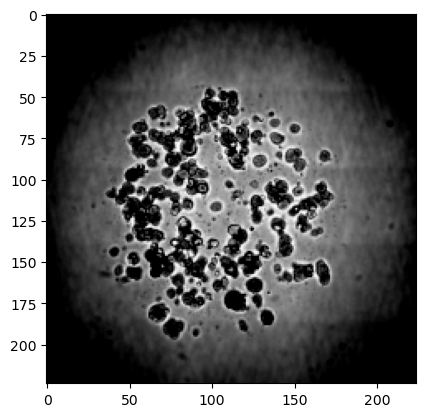

Epoch 1, Train Loss: 1.5105653620780783, Validation Loss: 1.22527843217055, Accuracy: 49.39434724091521 %
Class 0 F1 Score: 0.5176470588235295
Class 1 F1 Score: 0.44769874476987453
Class 2 F1 Score: 0.05084745762711864
Class 3 F1 Score: 0.0
Class 4 F1 Score: 0.6868686868686869
Class 5 F1 Score: 0.6250000000000001
Epoch 2, Train Loss: 1.1374419230095885, Validation Loss: 1.0452144915858905, Accuracy: 56.662180349932704 %
Class 0 F1 Score: 0.6593406593406593
Class 1 F1 Score: 0.050314465408805034
Class 2 F1 Score: 0.3937823834196892
Class 3 F1 Score: 0.0
Class 4 F1 Score: 0.8014705882352942
Class 5 F1 Score: 0.5454545454545455
Epoch 3, Train Loss: 0.956868164082791, Validation Loss: 1.018437293668588, Accuracy: 61.64199192462988 %
Class 0 F1 Score: 0.7205169628432957
Class 1 F1 Score: 0.3876651982378855
Class 2 F1 Score: 0.6209150326797386
Class 3 F1 Score: 0.0
Class 4 F1 Score: 0.7773279352226722
Class 5 F1 Score: 0.0
Epoch 4, Train Loss: 0.7963837892451184, Validation Loss: 0.791094326

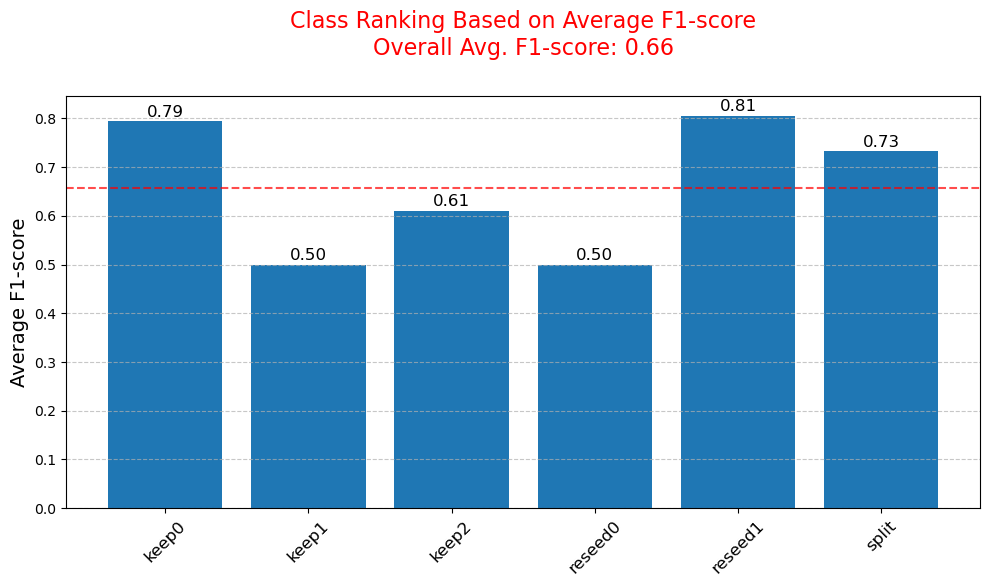

Training on fold 1/2
cuda


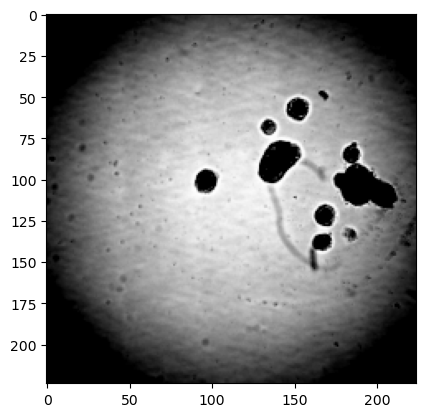

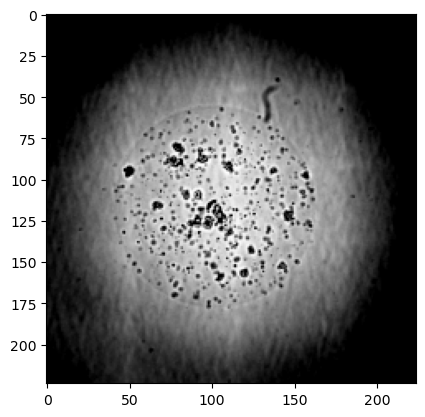

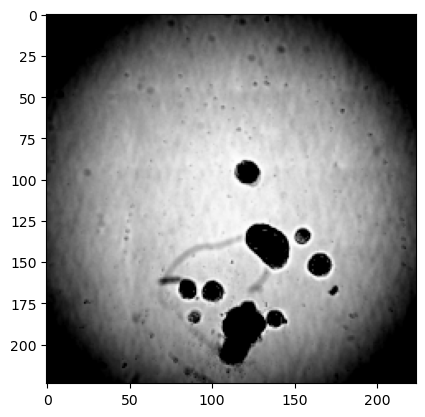

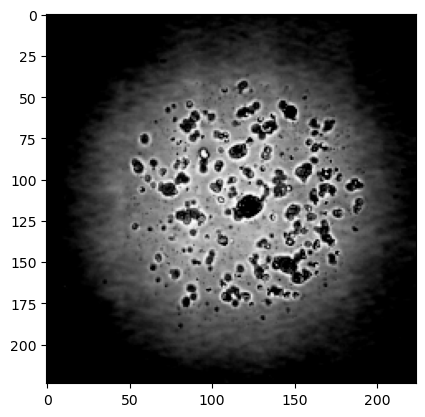

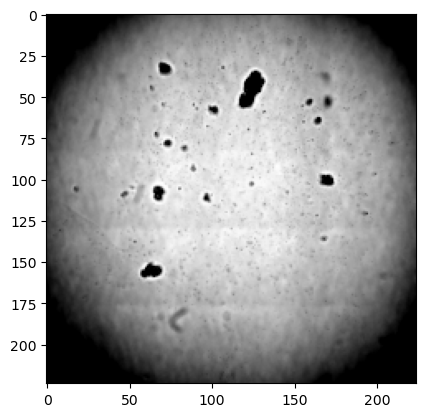

Epoch 1, Train Loss: 1.5659619671233156, Validation Loss: 1.3515872806310654, Accuracy: 45.356662180349936 %
Class 0 F1 Score: 0.6145251396648044
Class 1 F1 Score: 0.0
Class 2 F1 Score: 0.01680672268907563
Class 3 F1 Score: 0.0
Class 4 F1 Score: 0.5013333333333334
Class 5 F1 Score: 0.4313725490196078
Epoch 2, Train Loss: 1.167831077220592, Validation Loss: 1.1704327786962192, Accuracy: 51.41318977119785 %
Class 0 F1 Score: 0.6157760814249365
Class 1 F1 Score: 0.08284023668639053
Class 2 F1 Score: 0.2119205298013245
Class 3 F1 Score: 0.0
Class 4 F1 Score: 0.6816143497757848
Class 5 F1 Score: 0.6212121212121213
Epoch 3, Train Loss: 1.03680878624003, Validation Loss: 0.9467033073306084, Accuracy: 59.353970390309556 %
Class 0 F1 Score: 0.6449511400651465
Class 1 F1 Score: 0.3714285714285714
Class 2 F1 Score: 0.4216216216216216
Class 3 F1 Score: 0.0
Class 4 F1 Score: 0.8382352941176471
Class 5 F1 Score: 0.6785714285714285
Epoch 4, Train Loss: 0.9410682105003519, Validation Loss: 0.885214373

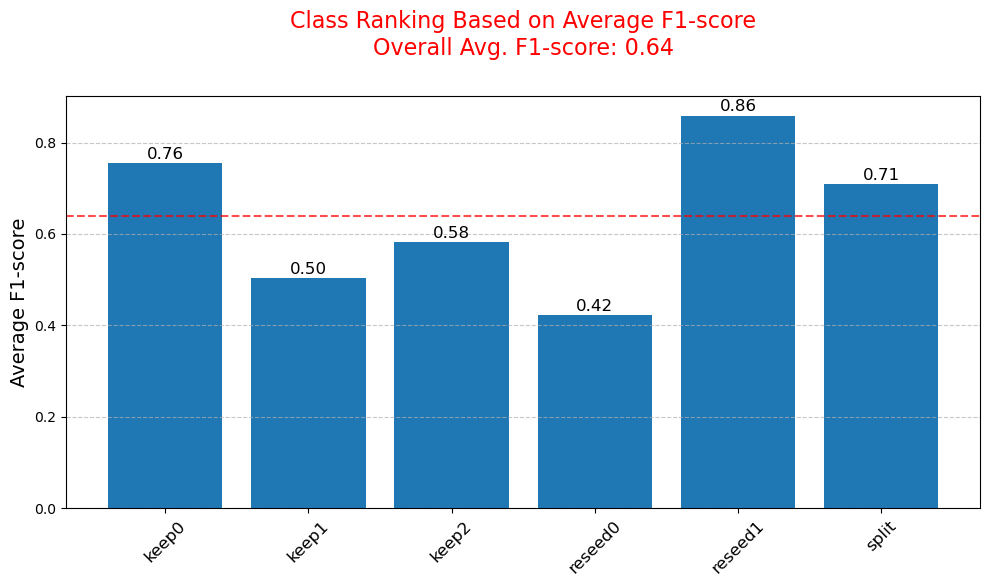

Training on fold 2/2
cuda


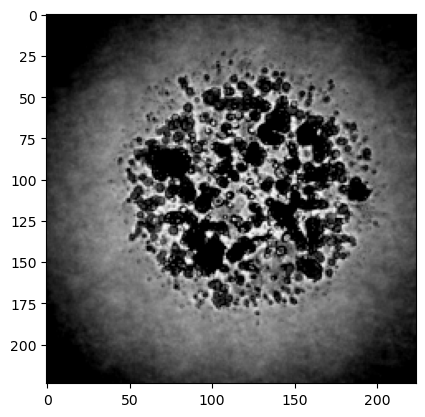

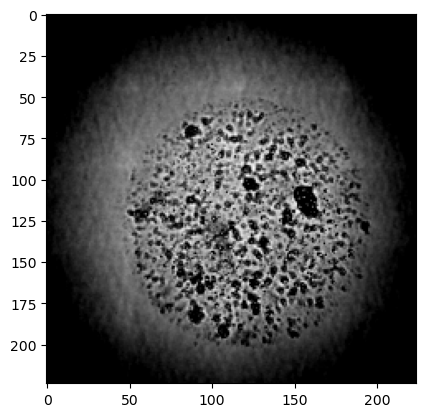

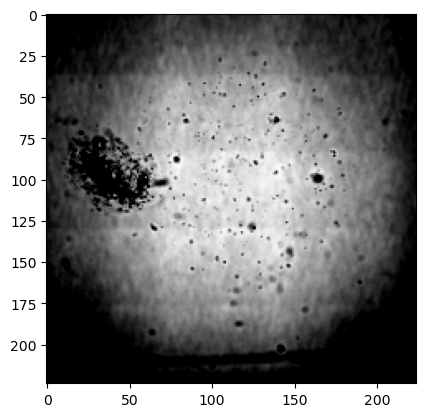

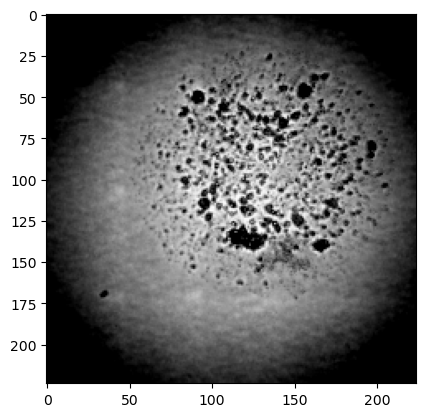

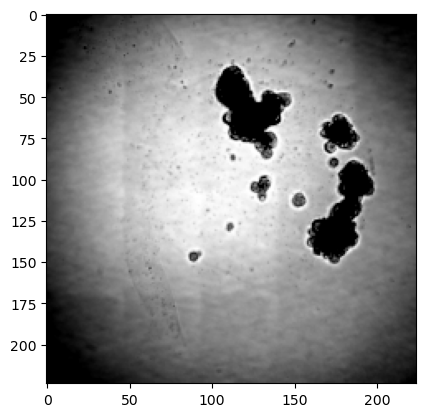

Epoch 1, Train Loss: 1.5674965888895886, Validation Loss: 1.2783710807561874, Accuracy: 44.54912516823688 %
Class 0 F1 Score: 0.5641025641025641
Class 1 F1 Score: 0.44504021447721176
Class 2 F1 Score: 0.2641509433962264
Class 3 F1 Score: 0.0
Class 4 F1 Score: 0.4361702127659575
Class 5 F1 Score: 0.2692307692307692
Epoch 2, Train Loss: 1.1722246395780684, Validation Loss: 1.331343090782563, Accuracy: 42.934051144010766 %
Class 0 F1 Score: 0.48062015503875966
Class 1 F1 Score: 0.0
Class 2 F1 Score: 0.3529411764705882
Class 3 F1 Score: 0.0
Class 4 F1 Score: 0.5447470817120622
Class 5 F1 Score: 0.4731182795698924
Epoch 3, Train Loss: 1.0372858884486746, Validation Loss: 1.324213405450185, Accuracy: 51.54777927321669 %
Class 0 F1 Score: 0.6392092257001647
Class 1 F1 Score: 0.026143790849673203
Class 2 F1 Score: 0.22222222222222218
Class 3 F1 Score: 0.4516129032258065
Class 4 F1 Score: 0.6095238095238096
Class 5 F1 Score: 0.5504587155963303
Epoch 4, Train Loss: 0.9681586914874137, Validation

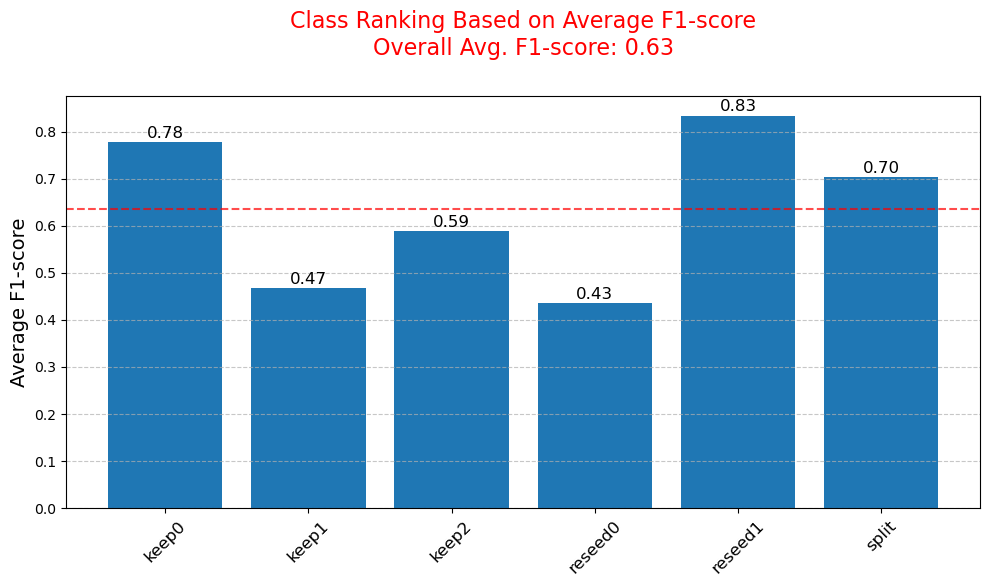

In [72]:
import torch
import wandb
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedKFold
import csv

model_names = ["microsoft/resnet-50", "microsoft/resnet-18", "microsoft/beit-base-patch16-224-pt22k-ft22k", "google/vit-base-patch16-224"]

for model_name in model_names:
    # Initialize a new wandb run
    wandb.init(project="organoid_classification", entity="laurent-gurtler")

    #hyperparameters to change or optimize for if needed 
    num_epochs = 50
    learning_rate = 5e-5
    batch_size = 64
    k_folds = 2
    weight_decay = 1e-5

    config = wandb.config
    config.learning_rate = learning_rate
    config.batch_size = batch_size
    config.num_epochs = num_epochs
    config.k_folds = k_folds
    config.weight_decay = weight_decay


    all_labels_list = ['keep0', 'keep1', 'keep2', 'reseed0', 'reseed1', 'split']

    all_fold_f1_scores = []
    num_labels = len(all_labels_list)  # The number of unique labels/classes in your dataset

    # Assuming PATHES_LIST contains paths to your different class directories
    img_labels = []
    img_sort = []
    for i, img_dir in enumerate(PATHES_LIST):
        img_files = sorted([f for f in os.listdir(img_dir) if f.endswith(".png")])
        img_labels.extend([i] * len(img_files))  # Labels for each image
        img_sort.extend([os.path.join(img_dir, f) for f in img_files])  # Paths for each image

    # Convert img_sort to a numpy array for easier indexing
    img_sort = np.array(img_sort)

    # Initialize StratifiedKFold
    kf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

    # Convert img_labels to numpy array for StratifiedKFold
    img_labels = np.array(img_labels)

    for fold, (train_idx, val_idx) in enumerate(kf.split(img_sort, img_labels)):
        print(f"Training on fold {fold+1}/{k_folds}")
        if "beit" in model_name:
            config = BeitConfig.from_pretrained(model_name, num_labels=num_labels)
            model = BeitForImageClassification(config)
        elif "resnet" in model_name:
            config = ResNetConfig.from_pretrained(model_name, num_labels=num_labels)
            model = ResNetForImageClassification(config)
        elif "vit" in model_name:
            config = ViTConfig.from_pretrained(model_name, num_labels=num_labels)
            model = ViTForImageClassification(config)
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

        # Split data into training and validation for this fold
        train_data = img_sort[train_idx]
        val_data = img_sort[val_idx]

        # Create datasets for this fold
        train_dataset = CustomImageDataset_train(train_data, img_labels[train_idx], 
                                                transform=False, 
                                                model_name=model_name)
        test_dataset = CustomImageDataset_test(val_data, img_labels[val_idx], 
                                            transform=False, 
                                            model_name=model_name)
        

        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(device)
        model.to(device)

        wandb.watch(model, criterion, log="all", log_freq=10)

        epoch_f1_scores_dict_list = []

        num_images_displayed = 0

        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            for images, labels in train_loader:
                if num_images_displayed < 5:  # Change 5 to however many batches you want to visualize
                    img = images[0].cpu().numpy()
                    img = np.transpose(img, (1,2,0))
                    img = np.clip(img,0,1)
                    plt.imshow(img)
                    plt.show()  # Display the first image in the batch
                    num_images_displayed += 1
                images = images.to(device)
                labels = labels.to(device)  # Convert labels to torch.long
                optimizer.zero_grad()
                outputs = model(images).logits
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            
            wandb.log({"fold": fold+1, "epoch": epoch, "train_loss": running_loss/len(train_loader)})

            # Validation phase
            model.eval()
            all_labels = []
            all_predictions = []
            validation_loss = 0.0
            correct = 0
            total = 0

            with torch.no_grad():
                for images, labels in test_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = model(images).logits
                    predicted = outputs.argmax(dim=1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    loss = criterion(outputs, labels)
                    validation_loss += loss.item()

                    # Move the labels and predictions to CPU for sklearn metrics
                    all_labels.extend(labels.cpu().numpy())
                    all_predictions.extend(predicted.cpu().numpy())

            # Calculate accuracy and F1 score
            accuracy = 100 * correct / total
            f1_scores = f1_score(all_labels, all_predictions, average=None, zero_division=0)  # This will give you an array of F1 scores per class
            # Check if the length of F1 scores matches the number of labels
            if len(f1_scores) != len(all_labels_list):
                print(f"Warning: Number of F1 scores ({len(f1_scores)}) does not match number of classes ({len(all_labels_list)})")
                # Trim the list of F1 scores to match the number of classes, if necessary
                f1_scores = f1_scores[:len(all_labels_list)]

            # Create a dictionary of class labels and their corresponding F1 scores
            f1_scores_dict = {all_labels_list[idx]: f1 for idx, f1 in enumerate(f1_scores)}
            epoch_f1_scores_dict_list.append(f1_scores_dict)

            # It might be useful to also get the classification report for all metrics
            classification_rep = classification_report(all_labels, all_predictions, output_dict=True, zero_division=0)

            # Logging the individual F1 scores
            for idx, f1 in enumerate(f1_scores):
                wandb.log({f"class_{idx}_f1_score": f1})


            wandb.log({"fold": fold+1, "epoch": epoch, "val_loss": validation_loss/len(test_loader), "val_accuracy": accuracy})

            # Print statistics for each class
            print(f"Epoch {epoch+1}, Train Loss: {running_loss/len(train_loader)}, "
                f"Validation Loss: {validation_loss/len(test_loader)}, Accuracy: {accuracy} %")
            for idx, f1 in enumerate(f1_scores):
                print(f"Class {idx} F1 Score: {f1}")

            for idx, f1 in enumerate(f1_scores):
                wandb.log({f"class_{idx}_f1_score": f1})

        # Access the F1-scores for the last epoch
            # Access the F1-scores for the last epoch of this fold
        last_epoch_f1_scores = epoch_f1_scores_dict_list[-1]

        # Append model name, fold number, and F1 scores to the list
        fold_data = {"model_name": model_name, "fold": fold + 1}
        fold_data.update(last_epoch_f1_scores)
        all_fold_f1_scores.append(fold_data)

        # Clear the epoch_f1_scores_dict_list for the next fold
        epoch_f1_scores_dict_list.clear()

        # The last_epoch_f1_scores already contains the F1 scores for each class from the last epoch
        # Optionally, you can directly plot these scores if needed
        plot_average_f1_scores(all_labels_list, last_epoch_f1_scores)


        # After the loop, you may want to log the overall performance
        wandb.log({
            "fold": fold+1, "final_accuracy": accuracy,
            "fold": fold+1, "final_f1_scores": f1_scores.tolist(),  # Convert to list if necessary
            "fold": fold+1, "final_classification_report": classification_rep
        })

        csv_filename = FILE_PATH + 'f1_scores_per_fold.csv'
        existing_data = []

        # Read existing data
        if os.path.exists(csv_filename):
            with open(csv_filename, 'r') as file:
                reader = csv.DictReader(file)
                existing_data = [row for row in reader]

        # Update or append new data
        for new_data in all_fold_f1_scores:
            model_found = False
            for existing_row in existing_data:
                if existing_row['model_name'] == new_data['model_name'] and existing_row['fold'] == str(new_data['fold']):
                    # Update existing row with new data
                    for key, value in new_data.items():
                        existing_row[key] = value
                    model_found = True
                    break
            if not model_found:
                # Convert numeric values to strings for CSV writing
                new_data_string = {k: str(v) for k, v in new_data.items()}
                existing_data.append(new_data_string)

        # Write updated data back to CSV
        header = ['model_name', 'fold'] + all_labels_list

        with open(csv_filename, 'w', newline='') as file:
            writer = csv.DictWriter(file, fieldnames=header)
            writer.writeheader()
            for data_row in existing_data:
                writer.writerow(data_row)

    # Close the wandb run
    wandb.finish()


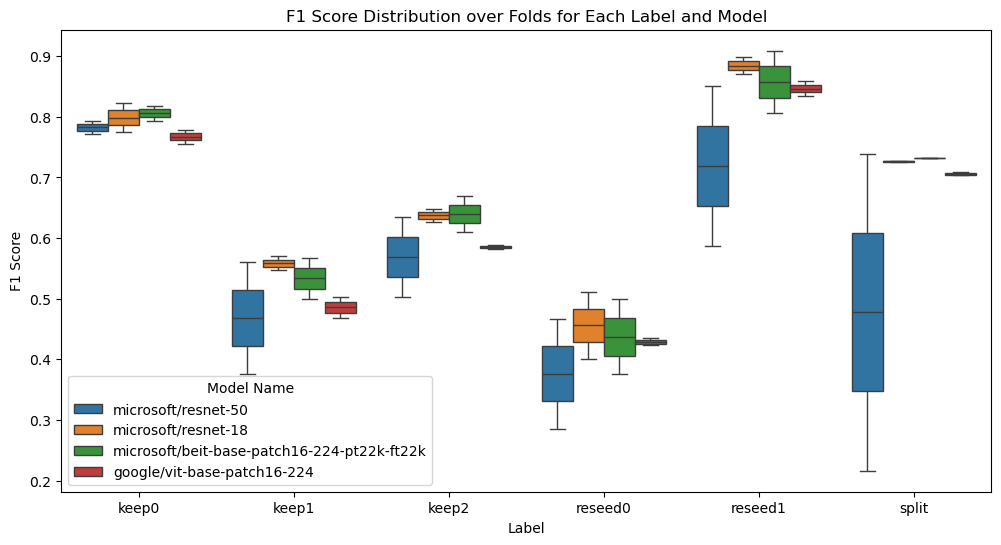

In [73]:
import seaborn as sns

df = pd.read_csv(csv_filename)
df_long = df.melt(id_vars=['model_name', 'fold'], 
                  value_vars=all_labels_list,  # list all your label columns here
                  var_name='label', value_name='f1_score')
# Creating a boxplot for each label within each model
plt.figure(figsize=(12, 6))

# You might need to adjust the size of the figure based on the number of models and labels
sns.boxplot(x='label', y='f1_score', hue='model_name', data=df_long)

plt.title('F1 Score Distribution over Folds for Each Label and Model')
plt.xlabel('Label')
plt.ylabel('F1 Score')
plt.legend(title='Model Name')
plt.show()